# Stroke Classification

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
import streamlit as st
print(f'Streamlit: {st.__version__}')
import sklearn as sk
print(f'Sklearn: {sk.__version__}')

Streamlit: 1.32.0
Sklearn: 1.4.2


## Data cleaning and prep

In [3]:
stroke_df = pd.read_csv("healthcare-dataset-stroke-data.csv")
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [4]:
# make a copy so we keep the original data untouched
stroke_copy = stroke_df.copy()

In [5]:
#with na's dropped we hardly lose data so we decided to just drop NA's
stroke_copy.dropna(inplace=True)

In [6]:
#The id column is irrelevant so just decided to drop it.
stroke_copy.drop(columns=['id'], inplace=True)

In [7]:
stroke_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   Residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     4909 non-null   object 
 10  stroke             4909 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 460.2+ KB


### One Hot Encoding to prep data for modeling.

In [8]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')

In [9]:
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [10]:
numerical_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

In [11]:
stroke_categorical = stroke_copy[categorical_columns]
stroke_numerical = stroke_copy[numerical_columns]

In [12]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
stroke_categorical = pd.DataFrame(data=ohe.fit_transform(stroke_categorical), 
                                           columns=ohe.get_feature_names_out(categorical_columns))

In [13]:
stroke_encoded = pd.concat([stroke_numerical.reset_index(drop=True), stroke_categorical.reset_index(drop=True)], axis=1)
stroke_encoded.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0


In [14]:
stroke_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4909 entries, 0 to 4908
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             4909 non-null   float64
 1   hypertension                    4909 non-null   int64  
 2   heart_disease                   4909 non-null   int64  
 3   avg_glucose_level               4909 non-null   float64
 4   bmi                             4909 non-null   float64
 5   stroke                          4909 non-null   int64  
 6   gender_Female                   4909 non-null   int64  
 7   gender_Male                     4909 non-null   int64  
 8   gender_Other                    4909 non-null   int64  
 9   ever_married_No                 4909 non-null   int64  
 10  ever_married_Yes                4909 non-null   int64  
 11  work_type_Govt_job              4909 non-null   int64  
 12  work_type_Never_worked          49

In [15]:
stroke_encoded['stroke'].value_counts(normalize=True)
#the data is very imbalanced so the data will need to be smoted or randomly resampled

stroke
0    0.957425
1    0.042575
Name: proportion, dtype: float64

## Data training and modeling ot figure out what method is better to balance the testing data

### Random Forest with balanced class weights

In [16]:
X = stroke_encoded.drop(columns = 'stroke')
y = stroke_encoded['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [17]:
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:
clf = RandomForestClassifier(random_state=42, n_estimators=500, class_weight='balanced')
clf.fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.9503257328990228


In [19]:
y_pred = clf.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))

[[1167    2]
 [  59    0]]


### Random forest with random oversampling

In [20]:
from imblearn.over_sampling import RandomOverSampler

# Instantiate the RandomOverSampler instance
random_oversampler = RandomOverSampler(random_state=42)

# Fit the data to the model
X_resampled, y_resampled = random_oversampler.fit_resample(X_train_scaled, y_train)
y_resampled.value_counts()

stroke
0    3531
1    3531
Name: count, dtype: int64

In [21]:
oversamp_forest = RandomForestClassifier(random_state=42, n_estimators=500, class_weight={0: 1, 1: 10})
oversamp_forest.fit(X_resampled, y_resampled)
print(f'Training Score: {oversamp_forest.score(X_resampled, y_resampled)}')
print(f'Testing Score: {oversamp_forest.score(X_test_scaled, y_test)}')


Training Score: 1.0
Testing Score: 0.9478827361563518


In [22]:
y_pred_resampled = oversamp_forest.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred_resampled))

[[1162    7]
 [  57    2]]


### Random forest using Smote

In [23]:
from imblearn.over_sampling import SMOTE
#Apply SMOTE to the training data:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)

# Check the new class distribution:
y_smote.value_counts()

stroke
0    3531
1    3531
Name: count, dtype: int64

In [24]:
smote_forest = RandomForestClassifier(random_state=42, n_estimators=500, class_weight={0: 1, 1: 10})
smote_forest.fit(X_smote, y_smote)
print(f'Training Score: {smote_forest.score(X_smote, y_smote)}')
print(f'Testing Score: {smote_forest.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.9201954397394136


In [25]:
y_pred_smote = smote_forest.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred_smote))

[[1127   42]
 [  56    3]]


### I am gonna move forward with smote because it tends to be better for overfitting and gives more variety for the minority class

### feature importances 

In [26]:
feature_importances = smote_forest.feature_importances_

In [27]:
importances_sorted = sorted(zip(feature_importances, X.columns), reverse=True)
importances_sorted[:10]

[(0.3261428433628137, 'age'),
 (0.14326985067782633, 'avg_glucose_level'),
 (0.14190648536227757, 'bmi'),
 (0.045433196353198674, 'ever_married_No'),
 (0.04408422453882088, 'ever_married_Yes'),
 (0.034519202217127606, 'work_type_children'),
 (0.031041649171595884, 'smoking_status_never smoked'),
 (0.025711017692923017, 'smoking_status_Unknown'),
 (0.023213884829799924, 'Residence_type_Urban'),
 (0.022976682548001122, 'hypertension')]

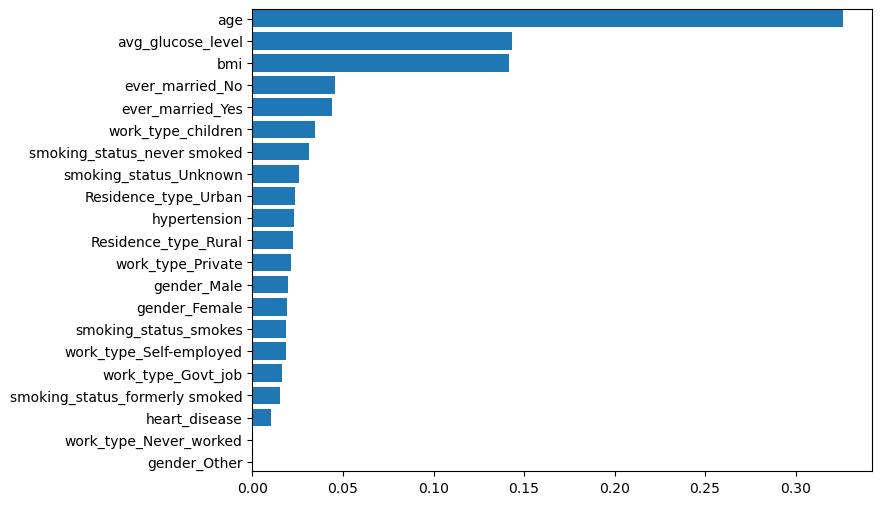

In [28]:
# Plot the feature importances
features = sorted(zip(X.columns, feature_importances), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(8,6)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

## hyperperamater tuning

In [29]:
#set params
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': [0.5, 'sqrt', 'log2'],  
    'max_depth': [5, 10, 20, 30],  # reduced max_depth options
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],  # increased min_samples_leaf to reduce overfitting
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 10}),
                               param_distributions=param_distributions, n_iter=100, cv=5, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X_smote, y_smote)

best_params = rf_random.best_params_
print("Best parameters found: ", best_params)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


In [30]:
random_rf_model = rf_random.best_estimator_

# Make predictions using the best model
best_rf_predictions = random_rf_model.predict(X_test_scaled)

# Evaluate the accuracy of the best model
random_accuracy = accuracy_score(y_test, best_rf_predictions)
print("Random accuracy: ", random_accuracy)

Random accuracy:  0.9030944625407166


In [31]:
random_model_preds = random_rf_model.predict(X_test_scaled)
print(confusion_matrix(y_test, random_model_preds))

[[1100   69]
 [  50    9]]


In [32]:
param_grid = {
    'max_features': [best_params['max_features']],
    'max_depth': [
        max(1, best_params['max_depth'] - 10), 
        best_params['max_depth'], 
        best_params['max_depth'] + 10
    ],
    'min_samples_leaf': [
        max(1, best_params['min_samples_leaf'] - 1), 
        best_params['min_samples_leaf'], 
        best_params['min_samples_leaf'] + 1
    ]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(
    random_state=42, class_weight={0: 1, 1: 10},
    n_estimators=best_params['n_estimators'], 
    min_samples_split=best_params['min_samples_split'], 
    bootstrap=best_params['bootstrap']
), param_grid=param_grid, cv=3)

grid_search.fit(X_smote, y_smote)

print("Best parameters after grid search: ", grid_search.best_params_)

Best parameters after grid search:  {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1}


In [33]:
final_model = grid_search.best_estimator_

In [34]:
print(f'Training Score: {final_model.score(X_resampled, y_resampled)}')
print(f'Testing Score: {final_model.score(X_test_scaled, y_test)}')

Training Score: 0.9990087793826111
Testing Score: 0.9177524429967426


In [35]:
# Confusion matrix for final model
best_model_preds = final_model.predict(X_test_scaled)
print(confusion_matrix(y_test, best_model_preds))

[[1124   45]
 [  56    3]]


### still not enough results in the minority so we will try some more agressive tactics

## SMOTETomek and ADASYN models to cater to the minority more

In [36]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_train_scaled, y_train)

In [37]:
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': [0.5, 'sqrt', 'log2'],  
    'max_depth': [5, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],  
    'bootstrap': [True, False],
    'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 15}]  # Tuning class_weight
}
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_distributions=param_distributions, n_iter=50, cv=5, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X_smote_tomek, y_smote_tomek)
best_params = rf_random.best_params_
print("Best parameters found: ", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'class_weight': {0: 1, 1: 10}, 'bootstrap': False}


In [38]:
best_rf_model = rf_random.best_estimator_
y_pred_smote_tomek = best_rf_model.predict(X_test_scaled)
smote_tomek_accuracy = accuracy_score(y_test, y_pred_smote_tomek)
print("Accuracy (SMOTE + Tomek Links): ", smote_tomek_accuracy)
print(confusion_matrix(y_test, y_pred_smote_tomek))

Accuracy (SMOTE + Tomek Links):  0.9047231270358306
[[1104   65]
 [  52    7]]


In [39]:
# Option 2: ADASYN
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train_scaled, y_train)

In [40]:
rf_random_adasyn = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                      param_distributions=param_distributions, n_iter=50, cv=5, 
                                      verbose=2, random_state=42, n_jobs=-1)
rf_random_adasyn.fit(X_adasyn, y_adasyn)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [{0: 1, 1: 5},
                                                         {0: 1, 1: 10},
                                                         {0: 1, 1: 15}],
                                        'max_depth': [5, 10, 20, 30],
                                        'max_features': [0.5, 'sqrt', 'log2'],
                                        'min_samples_leaf': [2, 4, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, verbose=2)

In [41]:
best_params_adasyn = rf_random_adasyn.best_params_
print("Best parameters found (ADASYN): ", best_params_adasyn)

Best parameters found (ADASYN):  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'class_weight': {0: 1, 1: 10}, 'bootstrap': False}


In [42]:
# Train the model with ADASYN data
best_rf_model_adasyn = rf_random_adasyn.best_estimator_

# Make predictions on the test set
y_pred_adasyn = best_rf_model_adasyn.predict(X_test_scaled)

In [43]:
# Evaluate the accuracy
adasyn_accuracy = accuracy_score(y_test, y_pred_adasyn)
print("Accuracy (ADASYN): ", adasyn_accuracy)
print(confusion_matrix(y_test, y_pred_adasyn))

Accuracy (ADASYN):  0.9030944625407166
[[1102   67]
 [  52    7]]


### The ADASYN model is so far the best model I have as far as predicting stroke.

In [44]:
from xgboost import XGBClassifier

# Train with ADASYN resampled data
xgb = XGBClassifier(scale_pos_weight=10, random_state=42) 
xgb.fit(X_adasyn, y_adasyn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [45]:
# Evaluate on the test set
y_pred_xgb = xgb.predict(X_test_scaled)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_accuracy}")
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.8835504885993485
[[1073   96]
 [  47   12]]


## Gradiant Boost Models

### Gradiant Boost with Smote

In [46]:
# Initialize GradientBoostingClassifier
gbc_smote = GradientBoostingClassifier(random_state=42)

# Train the model on the ADASYN resampled data
gbc_smote.fit(X_smote, y_smote)


GradientBoostingClassifier(random_state=42)

In [47]:
print(f'Training Score: {gbc_smote.score(X_smote, y_smote)}')
print(f'Testing Score: {gbc_smote.score(X_test_scaled, y_test)}')

Training Score: 0.9229679977343529
Testing Score: 0.8680781758957655


In [48]:
# Make predictions
y_pred_gbc_smote = gbc_smote.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred_gbc_smote))

[[1048  121]
 [  41   18]]


### Gradiant Bost with SmoteTomek

In [49]:
# Initialize GradientBoostingClassifier
gbc_smotetomek = GradientBoostingClassifier(random_state=42)

# Train the model on the ADASYN resampled data
gbc_smotetomek.fit(X_smote_tomek, y_smote_tomek)


GradientBoostingClassifier(random_state=42)

In [50]:
print(f'Training Score: {gbc_smotetomek.score(X_smote_tomek, y_smote_tomek)}')
print(f'Testing Score: {gbc_smotetomek.score(X_test_scaled, y_test)}')

Training Score: 0.9237674551154175
Testing Score: 0.8664495114006515


In [51]:
# Make predictions
y_pred_gbc_tomek = gbc_smotetomek.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred_gbc_tomek))

[[1045  124]
 [  40   19]]


### Gradiant Boost with Adasyn

In [52]:
# Initialize GradientBoostingClassifier
gbc_adasyn = GradientBoostingClassifier(random_state=42)

# Train the model on the ADASYN resampled data
gbc_adasyn.fit(X_adasyn, y_adasyn)


GradientBoostingClassifier(random_state=42)

In [53]:
print(f'Training Score: {gbc_adasyn.score(X_adasyn, y_adasyn)}')
print(f'Testing Score: {gbc_adasyn.score(X_test_scaled, y_test)}')

Training Score: 0.9203136136849608
Testing Score: 0.8721498371335505


In [54]:
# Make predictions
y_pred_gbc_adasyn = gbc_adasyn.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred_gbc_adasyn))

[[1052  117]
 [  40   19]]


## Hyper tune gradiant boost model

In [55]:
# # Define the parameter grid
# param_distributions = {
#     'n_estimators': [100, 200, 300, 500, 1000],
#     'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
#     'max_depth': [3, 4, 5, 6],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'subsample': [0.7, 0.8, 0.9, 1.0],
#     'max_features': ['sqrt', 'log2', None]
# }

# # Initialize the GradientBoostingClassifier
# gbc = GradientBoostingClassifier(random_state=42)

# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=gbc,
#     param_distributions=param_distributions,
#     n_iter=100,  # number of random combinations to try
#     cv=5,  # 5-fold cross-validation
#     verbose=2,
#     random_state=42,
#     n_jobs=-1  # Use all cores
# )

# # Train on SMOTE resampled data
# random_search.fit(X_smote, y_smote)

# # Print the best parameters found by RandomizedSearchCV
# print("Best Parameters: ", random_search.best_params_)

In [56]:
# # Evaluate the model with the best hyperparameters on the test set
# best_gbc = random_search.best_estimator_
# print(f'Training Score: {best_gbc.score(X_smote, y_smote)}')
# print(f'Testing Score: {best_gbc.score(X_test_scaled, y_test)}')
# # Make predictions
# y_pred_best_gbc = best_gbc.predict(X_test_scaled)
# print(confusion_matrix(y_test, y_pred_best_gbc))

In [57]:
# best_params = random_search.best_params_  # instead of params from other models

# # Check the best parameters before using them
# print("Best Parameters from RandomizedSearchCV: ", best_params)

# # Define the refined parameter grid based on the GradientBoostingClassifier best_params
# param_grid = {
#     'n_estimators': [best_params['n_estimators'] - 100, best_params['n_estimators'], best_params['n_estimators'] + 100],
#     'learning_rate': [best_params['learning_rate'] * 0.5, best_params['learning_rate'], best_params['learning_rate'] * 2],
#     'max_depth': [max(1, best_params['max_depth'] - 1), best_params['max_depth'], best_params['max_depth'] + 1],
#     'min_samples_split': [best_params['min_samples_split'] - 1, best_params['min_samples_split'], best_params['min_samples_split'] + 1],
#     'min_samples_leaf': [best_params['min_samples_leaf'] - 1, best_params['min_samples_leaf'], best_params['min_samples_leaf'] + 1],
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=best_gbc,  # Use the best GradientBoostingClassifier estimator from RandomizedSearchCV
#     param_grid=param_grid,
#     cv=3,  
#     verbose=2,
#     n_jobs=-1  
# )

# # Fit the grid search on the SMOTE data
# grid_search.fit(X_smote, y_smote)

# # Print the best parameters from GridSearchCV
# print("Best Parameters after GridSearch: ", grid_search.best_params_)

In [58]:
# # Evaluate the grid-tuned model on the test set
# final_gbc = grid_search.best_estimator_
# print(f'Training Score: {final_gbc.score(X_smote, y_smote)}')
# print(f'Testing Score: {final_gbc.score(X_test_scaled, y_test)}')

# # Make predictions
# y_pred_final_gbc = final_gbc.predict(X_test_scaled)
# print(confusion_matrix(y_test, y_pred_final_gbc))